# Multi-agent Collaboration

In [2]:
# Dependency
# !pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

### Read APIs

In [3]:
import os
openai_api_key = os.getenv('OPENAI_API_KEY')
langchain_api_key = os.getenv('LANGCHAIN_API_KEY')
tavily_api_key = os.getenv('TAVILY_API_KEY')

## Create Agents

In [4]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                " You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message} (if needed)"
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

## Define tools

In [5]:
from typing import Annotated
import fitz  # PyMuPDF
import requests
from io import BytesIO
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=3)

# Warning: This executes code locally, which can be unsafe when not sandboxed


@tool
def identify_exchange_market(url: str) -> str:
    """
    Inference the exchange market the company is listed on using the URL of a report PDF.
    Parameters:
    url (str): The URL to be checked.
    Returns:
    str: The name of the exchange.
    """
    if "sse.com.cn" in url:
        return "上海交易所"
    elif "szse.cn" in url:
        return "深圳交易所"
    elif "sgx.com" in url:
        return "新加坡交易所"
    elif "hkexnews.hk" in url:
        return "香港交易所"
    else:
        return "no match is found"  # Return "Unknown Exchange" if no match is found
    



@tool
def extract_pdf_text_from_url(url: str, page_number: int) -> str:
    """
    Extracts text from a specified page number from a PDF file available at a given URL.
    Args:
        url (str): The URL of the PDF file.
        page_number (int): The page number to extract text from (1-based index).
    Returns:
        str: The extracted text from the specified page, limited to 300 words..
    Raises:
        ValueError: If the URL is invalid or the page number exceeds the total pages in the PDF.
    """
    # Download the PDF file
    response = requests.get(url)
    pdf_data = BytesIO(response.content)

    # Open the PDF file
    document = fitz.open(stream=pdf_data, filetype="pdf")

    # Validate the page number
    if page_number < 1 or page_number > len(document):
        raise ValueError("Page number out of range")

    # Extract text from the specified page (0-based index for PyMuPDF)
    page = document.load_page(page_number - 1)
    page_text = page.get_text()

    # Limit the text to 200 words
    words = page_text.split()
    if len(words) > 200:
        words = words[:200]
    limited_text = ' '.join(words)

    return limited_text

## Create graph

### Define State

We first define the state of the graph. This will just a list of messages, along with a key to track the most recent sender

In [6]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_openai import ChatOpenAI


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

### Define Agent Nodes

In [7]:
import functools

from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4o")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate information for use"
        "clearly predict the page number of the potential information"
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# stock_market_agent
Stock_Market_Agent = create_agent(
    llm,
    [identify_exchange_market],
    system_message="Inference the exchange market the company is listed on using the URL of a report PDF.",
)
chart_node = functools.partial(agent_node, agent=Stock_Market_Agent, name="stock_market_agent")

# pdf_agent
pdf_agent = create_agent(
    llm,
    [extract_pdf_text_from_url],
    system_message="Extracts text from a specified page number from a PDF file available at a given URL.",
)
pdf_node = functools.partial(agent_node, agent=pdf_agent, name="pdf_agent")

### Define Tool Node

In [8]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, identify_exchange_market, extract_pdf_text_from_url]
tool_node = ToolNode(tools)

### Define Edge Logic

In [9]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

### Define the Graph

In [10]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("stock_market_agent", chart_node)
workflow.add_node("pdf_agent", pdf_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "stock_market_agent", "continue": "pdf_agent","call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "stock_market_agent",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "pdf_agent",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "stock_market_agent": "stock_market_agent",
        "pdf_agent": "pdf_agent",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()

### Display the Graph

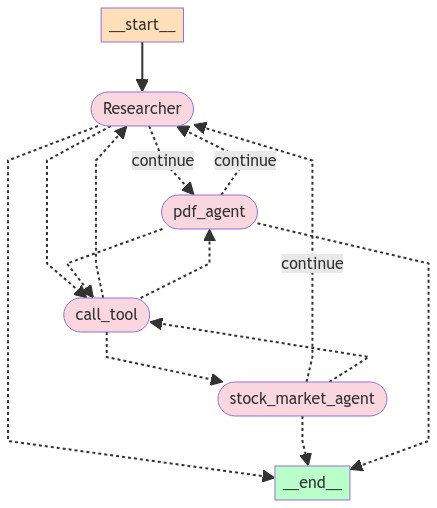

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Invoke

In [14]:
url = "https://www.seadrill.com/wp-content/uploads/2024/01/Seadrill_-Sustainability-2022.pdf"

config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content=
                f"The pdf ({url}) is an ESG report from a company."
                " MUST RETURN (in PDF's language):"
                " 1. The exchange market the company is listed on."
                " 2. The report name."
                " 3. The reporting period."
                " 4. The report release date."
                " 5. The company listed stock name."
                " 6. The company listed stock code."
                " 7. The company full name."
                " 8. The Industry classification of the company's main business operations."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    config={"recursion_limit": 50},
    stream_mode="values"
)
for event in events:
    # print(event)
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

The pdf (https://www.seadrill.com/wp-content/uploads/2024/01/Seadrill_-Sustainability-2022.pdf) is an ESG report from a company. MUST RETURN (in PDF's language): 1. The exchange market the company is listed on. 2. The report name. 3. The reporting period. 4. The report release date. 5. The company listed stock name. 6. The company listed stock code. 7. The company full name. 8. The Industry classification of the company's main business operations.
================================== Ai Message ==================================
Name: Researcher
Tool Calls:
  tavily_search_results_json (call_RNe1Yfjp9idA8ziVie45wXeq)
 Call ID: call_RNe1Yfjp9idA8ziVie45wXeq
  Args:
    query: Seadrill Sustainability 2022 ESG report
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.seadrill.com/wp-content/uploads/2024/01/Seadrill_-Sustainab